In [1]:
from readRinexObs import rinexobs
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
from pandas import DataFrame

In [2]:
data = rinexobs("mah22800.15o")

mah22800.15o is a RINEX 2.11 file.
16.10 seconds for _block2df
7.94 seconds for panel assignments
finished in 26.07 seconds


This script filters the data from the rinex file to look at only the first tlim points, which in this case turns out to be from about 6-7 UTC. It then further filters the points to only include satellites with a minimum of minpoints L1, L2, C1, and C2 values that aren't Nan. Finally only points with TEC values between 0 and 200 (in TECu, I believe) are included in the final dataframe, interesting_data. TEC is calculated according to the method in Bill Rideout's program, tec.py. NOTE: in his program, he only plots short blocks of data, about 30 seconds in length according to him, at a time, where there are no large (>1 TECu) jumps in TEC. I included all the data from 6-7 UTC and it is pretty messy. 

SVN: 3, Pts above 200: 1, Pts below zero: 42, NaNs: 240
SVN: 6, Pts above 200: 1, Pts below zero: 0, NaNs: 0
SVN: 9, Pts above 200: 0, Pts below zero: 1, NaNs: 3
SVN: 26, Pts above 200: 0, Pts below zero: 17, NaNs: 45


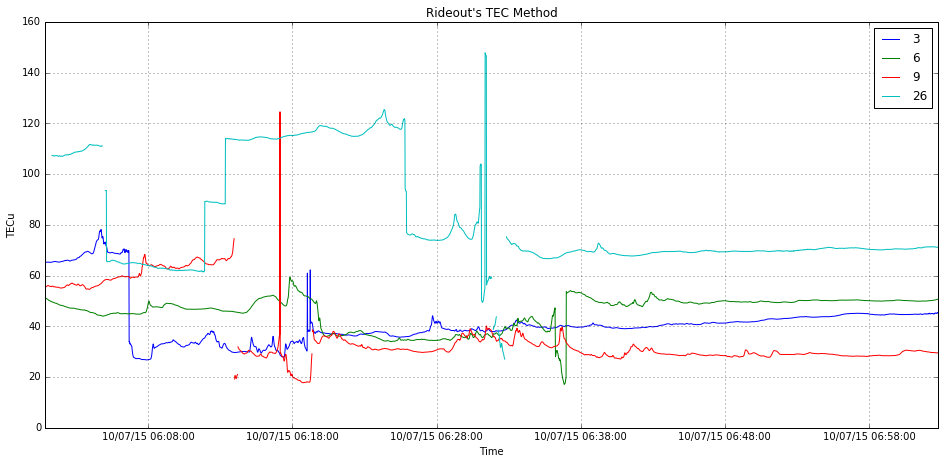

In [3]:
fig = plt.figure(figsize=(14,14))
tlim = 4000
minpoints = 3000

svs_with_pts_in_range = [i for i in data.items if(np.sum(np.logical_and.reduce(
                (data[data.labels[:tlim],i,'L1','data']>0,
                 data[data.labels[:tlim],i,'L2','data']>0,
                 data[data.labels[:tlim],i,'C1','data']>0,
                 data[data.labels[:tlim],i,'C2','data']>0)))>minpoints)]

#Bill's Calculation:
convertL1ToMeters = 3.0E8/(154.0*10.23E6)
convertL2ToMeters = 3.0E8/(120.0*10.23E6)
f2f1Factor = 1.545727
convertMetersToTEC = 6.158

interesting_data = DataFrame()

for sv in svs_with_pts_in_range:
    diffrange = data[data.labels[:tlim],sv,'C2','data']-data[data.labels[:tlim],sv,'C1','data']
    diffrange = diffrange*convertMetersToTEC*f2f1Factor
    phase = f2f1Factor*(convertL1ToMeters*data[data.labels[:tlim],sv,'L1','data']
                        -convertL2ToMeters*data[data.labels[:tlim],sv,'L2','data'])

    phase = phase*convertMetersToTEC
    median = sorted(list(phase-diffrange))[int(len(diffrange)/2)]
    TEC = phase-median
    interesting_data[sv]=TEC[np.logical_and(TEC<200,TEC>0)]

    print("SVN: {}, Pts above 200: {}, Pts below zero: {}, NaNs: {}".format(sv,
                                                                            np.sum(TEC>200),
                                                                            np.sum(TEC<0),
                                                                            np.sum(np.isnan(TEC))))
    
    
fig = plt.figure(figsize=(16,16))
ax1 = plt.subplot(211)
fmt = DateFormatter('%D %H:%M:%S')
ax1.xaxis.set_major_formatter(fmt)
ax1.autoscale_view()
plt.xlabel('Time')
plt.ylabel('TECu')
plt.title("Rideout's TEC Method")

lines = plt.plot(interesting_data)
plt.legend(lines,interesting_data.columns)
plt.grid()
plt.show()